**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Proyecto integrador**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 6**
Avance 5. Modelo final
---

*  Salvador Martínez Morales A01273366
*  Fernando Acevedo Ortegate A01794022
*  José Francisco Miranda García A00837306


Como parte del avance en esta actividad, retomaremos lo trabajado la semana pasada, realizando un análisis más exhaustivo de los ajustes implementados.

### Importamos librerías necesarias

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import mysql.connector
import matplotlib.pyplot as plt

import ast

In [324]:
# !pip install mysql-connector-python==8.0.32

In [325]:
# Obtiene IP del NoteBook

# !curl ipecho.net/plain

### Conexión a base de datos y extracción de información

Para este primer ejercicio de comprensión de datos, extraeremos solo 1000 registros, de los cuales seleccionaremos las columnas que mejor describan la operación de cada una de las sucursales que analizaremos.

In [326]:
# Configura conexión con base de datos de MYSql alojada en GCP

db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Test123@",
  database="DB_ZAB"
)

cursor = db_connection.cursor()

In [327]:
# Valida estatus de conexión

cursor.execute("SELECT VERSION()")
testConnection = cursor.fetchone()
print(f"Database version: {testConnection[0]}")

Database version: 9.0.1


Para la consulta, utilizaremos una parte de los datos que deseamos analizar. En este caso, nos interesan las siguientes columnas:
* vch_identifier: corresponde al identificador de la sucursal.
* txt_prediction: contiene objetos tipo JSON con diversos valores, como tiempo de servicio, tiempo de espera y número de cajas abiertas por hora.
* TXT_Real: contiene valores reales referente a los tiempor por hora y los checkouts
* int_checkouts: número de checkouts propuestos.
* FLT_TimeAttentionReal: tiempo real de atención.

Todos estos datos provienen de nuestra tabla principal TBL_Snapshots.

In [328]:
# Definimos una sucursal objetivo para nuestro análisis
suc_objetivo = 'ZCL'

In [329]:
# Query de consulta, el tamaño actual de registros para la sucursal ZCL es de 850 registros
query = f"SELECT vch_identifier, txt_prediction, TXT_Real,INT_CheckoutsReal, FLT_TimeAttentionReal, DTT_Date FROM TBL_Snapshots where vch_identifier = '{suc_objetivo}' order by DTT_Date;"


In [330]:
# Cargamos los datos en un DataFrame para realizar el análisis a continuación
data = pd.read_sql(query, con=db_connection)
db_connection.close()

# Imprimimos los primeros 5 registros
data.head()

C:\Users\SALVA\AppData\Local\Temp\ipykernel_17512\1403606791.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, con=db_connection)


,vch_identifier,txt_prediction,TXT_Real,INT_CheckoutsReal,FLT_TimeAttentionReal,DTT_Date
0,ZCL,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...","{""checkouts"":{""6"":1,""7"":4,""8"":4,""9"":5,""10"":6,""...",6.0,151.656,2017-02-22
1,ZCL,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...","{""checkouts"":{""6"":1,""7"":5,""8"":5,""9"":5,""10"":5,""...",5.0,134.992,2017-02-23
2,ZCL,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...","{""checkouts"":{""6"":1,""7"":5,""8"":5,""9"":5,""10"":5,""...",6.0,146.285,2017-02-24
3,ZCL,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...","{""checkouts"":{""6"":2,""7"":6,""8"":7,""9"":7,""10"":6,""...",7.0,179.909,2017-05-22
4,ZCL,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...","{""checkouts"":{""6"":1,""7"":5,""8"":5,""9"":5,""10"":5,""...",6.0,133.156,2017-05-25


In [331]:
# Se procesan los datos a formato JSON para nuestro objeto TXT_Real

data.TXT_Real = data.TXT_Real.apply(lambda x: json.loads(x) if isinstance(x, str) else x)

In [332]:
# Se procesan los datos a formato JSON para nuestro objeto txt_prediction

data.txt_prediction = data.txt_prediction.apply(lambda x: json.loads(x) if isinstance(x, str) else x)

In [333]:
# Se extraen las características Llegadas y checkout por tiempo

data['checkouts_by_time'] = data.TXT_Real.apply(lambda x: x['checkouts'] if x is not None else None)
data['arrives_by_time'] = data.TXT_Real.apply(lambda x: x['arrives'] if x is not None else None)


In [334]:
# Se extraen las característicast tiempo de servicio, costo promedio y tiempo de espera

data['costs_avg_by_time'] = data.txt_prediction.apply(lambda x: x['graphs']['costs'][0])
data['services_by_time'] = data.txt_prediction.apply(lambda x: x['graphs']['services'][0])
data['waitings_by_time'] = data.txt_prediction.apply(lambda x: x['graphs']['waitings'][0])

In [335]:
# Renombramos las columnas para facilitar su interpretación

data = data.rename(columns={
    'vch_identifier': 'store', # Identificador de 3 letras de la sucursal
    'FLT_TimeAttentionReal': 'avg_real_time_service', # Tiempo promedio de servicio real
    'DTT_Date': 'date' # Fecha de la toma de datos
})

In [336]:
# Eliminamos las columnas que no son necesarias para nuestro análisis

data = data.drop(columns=['txt_prediction','TXT_Real','INT_CheckoutsReal'])

In [337]:
# Imprimimos los primeros 5 registros

data.head()

,store,avg_real_time_service,date,checkouts_by_time,arrives_by_time,costs_avg_by_time,services_by_time,waitings_by_time
0,ZCL,151.656,2017-02-22,"{'6': 1, '7': 4, '8': 4, '9': 5, '10': 6, '11'...","{'6': 1, '7': 39, '8': 42, '9': 64, '10': 60, ...","[41.56, 16851.93, 35313.85, 27364.48, 32126.57...","[0.1, 1.8, 2.5, 2.1, 2.2, 2.6, 2.3, 2.2, 1.9, ...","[2.2, 7.9, 9, 8.4, 7.9, 7.9, 8.1, 9, 9.5, 8.1,..."
1,ZCL,134.992,2017-02-23,"{'6': 1, '7': 5, '8': 5, '9': 5, '10': 5, '11'...","{'6': 1, '7': 41, '8': 42, '9': 41, '10': 44, ...","[0.76, 24979.59, 27616.07, 29976.49, 35022.85,...","[0.0, 2.5, 2.1, 2.3, 2.4, 2.6, 2.3, 2.4, 2.2, ...","[1, 8.3, 8.5, 9.2, 8.2, 9.2, 9.7, 7.8, 9.1, 8...."
2,ZCL,146.285,2017-02-24,"{'6': 1, '7': 5, '8': 5, '9': 5, '10': 5, '11'...","{'6': 1, '7': 24, '8': 52, '9': 44, '10': 42, ...","[72.98, 15169.02, 37467.41, 30939.48, 32795.97...","[0.2, 2.0, 2.6, 2.2, 2.5, 2.3, 2.3, 2.1, 2.3, ...","[1, 8.1, 8.6, 8.2, 9.7, 8.8, 9.6, 8.2, 8.2, 9...."
3,ZCL,179.909,2017-05-22,"{'6': 2, '7': 6, '8': 7, '9': 7, '10': 6, '11'...","{'6': 2, '7': 28, '8': 56, '9': 71, '10': 70, ...","[9.36, 26967.18, 53036.04, 46472.39, 42413.36,...","[0.2, 2.7, 3.5, 2.9, 2.8, 2.9, 2.8, 3.0, 3.4, ...","[2.7, 8.4, 9.5, 8.7, 9.8, 8.7, 8.7, 9.6, 9.1, ..."
4,ZCL,133.156,2017-05-25,"{'6': 1, '7': 5, '8': 5, '9': 5, '10': 5, '11'...","{'6': 1, '7': 30, '8': 59, '9': 43, '10': 42, ...","[98.96, 19592.72, 35456.12, 30096.94, 30535.96...","[0.4, 2.3, 2.5, 2.3, 2.4, 2.5, 2.4, 2.6, 2.5, ...","[2.3, 7.3, 8.9, 8.5, 9.3, 9.6, 8.9, 8.9, 8.4, ..."


## Parte 1, análisis de datos

**Estracción de datos para las columnas tipo JSON**

* checkouts_by_time
* arrives_by_time
* costs_avg_by_time
* services_by_time
* waitings_by_time

In [338]:
# Identificar las columnas con objetos JSON

json_columns = ['services_by_time', 'arrives_by_time', 'checkouts_by_time', 'waitings_by_time', 'costs_avg_by_time']

In [339]:
# Procesamiento de datos y de formato JSON para procesamiento de datos

json_column_types = {col: data[col].apply(type).value_counts() for col in json_columns}
print("Tipos de datos por columna JSON:", json_column_types)

Tipos de datos por columna JSON: {'services_by_time': services_by_time
<class 'list'>    808
Name: count, dtype: int64, 'arrives_by_time': arrives_by_time
<class 'dict'>        802
<class 'NoneType'>      6
Name: count, dtype: int64, 'checkouts_by_time': checkouts_by_time
<class 'dict'>        802
<class 'NoneType'>      6
Name: count, dtype: int64, 'waitings_by_time': waitings_by_time
<class 'list'>    808
Name: count, dtype: int64, 'costs_avg_by_time': costs_avg_by_time
<class 'list'>    808
Name: count, dtype: int64}


In [340]:
# Limpiar los valores NaN y valores float no convertibles

data['arrives_by_time'] = data['arrives_by_time'].apply(lambda x: '{}' if isinstance(x, float) else x)
data['checkouts_by_time'] = data['checkouts_by_time'].apply(lambda x: '{}' if isinstance(x, float) else x)

In [341]:
# Convertir las columnas JSON de string a objetos

for col in json_columns:
    data[col] = data[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [342]:
# Expandimos las columnas JSON en columnas individuales

data_clean = data.copy()

for col in json_columns:
    if isinstance(data_clean[col][0], list):
        expanded_df = pd.DataFrame(data_clean[col].tolist(), index=data_clean.index)
        expanded_df.columns = [f"{col}_{i}" for i in range(len(expanded_df.columns))]
    else:
        expanded_df = pd.json_normalize(data_clean[col])
        expanded_df.columns = [f"{col}_{hour}" for hour in expanded_df.columns]
    
    data_clean = pd.concat([data_clean.drop(columns=[col]), expanded_df], axis=1)

In [343]:
# DF final

display(data_clean.head())

,store,avg_real_time_service,date,services_by_time_0,services_by_time_1,services_by_time_2,services_by_time_3,services_by_time_4,services_by_time_5,services_by_time_6,...,costs_avg_by_time_6,costs_avg_by_time_7,costs_avg_by_time_8,costs_avg_by_time_9,costs_avg_by_time_10,costs_avg_by_time_11,costs_avg_by_time_12,costs_avg_by_time_13,costs_avg_by_time_14,costs_avg_by_time_15
0,ZCL,151.656,2017-02-22,0.1,1.8,2.5,2.1,2.2,2.6,2.3,...,26800.01,24083.34,20443.84,20585.23,20208.28,31409.51,20613.55,20204.84,1441.51,0
1,ZCL,134.992,2017-02-23,0.0,2.5,2.1,2.3,2.4,2.6,2.3,...,27145.99,26010.47,24657.51,22222.13,19388.83,23876.88,25841.25,14462.47,1369.45,0
2,ZCL,146.285,2017-02-24,0.2,2.0,2.6,2.2,2.5,2.3,2.3,...,35588.09,30478.58,28249.87,26661.39,23485.09,26808.46,24530.53,20907.13,4597.26,0
3,ZCL,179.909,2017-05-22,0.2,2.7,3.5,2.9,2.8,2.9,2.8,...,48172.50,53647.62,44747.64,47568.03,39347.02,36543.17,35817.17,30170.13,9321.07,0
4,ZCL,133.156,2017-05-25,0.4,2.3,2.5,2.3,2.4,2.5,2.4,...,34964.67,28061.68,24612.98,25676.37,21212.87,24700.35,28830.97,19480.32,4693.53,0


**Para nuestro análisis agruparemos cada columna en su respectiva categoría donde se busca que cada una sea el promedio de los valores extraidos en el paso anterior**

In [344]:
data_clean_num = data_clean.apply(pd.to_numeric, errors='coerce')

# Agrupar las columnas por categoría y calcular el promedio
grouped_averages = {
    'services_by_time': data_clean_num.filter(regex='^services_by_time').mean(axis=1),
    'arrives_by_time': data_clean_num.filter(regex='^arrives_by_time').mean(axis=1),
    'checkouts_by_time': data_clean_num.filter(regex='^checkouts_by_time').mean(axis=1),
    'waitings_by_time': data_clean_num.filter(regex='^waitings_by_time').mean(axis=1),
    'costs_avg_by_time': data_clean_num.filter(regex='^costs_avg_by_time').mean(axis=1)
}

# Convertir a DataFrame y añadir las columnas 'store', 'date' y 'avg_real_time_service'
data_group = pd.concat([data_clean[['store', 'date', 'avg_real_time_service']], pd.DataFrame(grouped_averages)], axis=1)
data_group['date'] = pd.to_datetime(data_group['date']).dt.strftime('%Y-%m-%d')

data_group.head()

,store,date,avg_real_time_service,services_by_time,arrives_by_time,checkouts_by_time,waitings_by_time,costs_avg_by_time
0,ZCL,2017-02-22,151.656,1.93750,36.8125,4.3125,7.56250,20912.840625
1,ZCL,2017-02-23,134.992,2.00000,31.5625,4.0625,7.23750,21118.388750
2,ZCL,2017-02-24,146.285,2.18125,38.1875,4.3750,7.35625,22953.461875
3,ZCL,2017-05-22,179.909,2.68125,43.5000,5.3750,7.95625,35134.530000
4,ZCL,2017-05-25,133.156,2.28750,33.5625,4.1875,7.42500,22417.486875


### Proceso de análisis de información y estadisticas descriptivas

Estadísiticas descriptivas

En esta sección, podemos observar de manera general los valores de nuestros datos, tanto en sus estadísticas descriptivas como en los tipos de datos correspondientes.

In [345]:
# Definir las columnas de interés basadas en las métricas de análisis

metrics_columns = [col for col in data_group.columns if any(metric in col for metric in [
    "services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time", "costs_avg_by_time"])]

In [346]:
# Descripción de las columnas de interés

data_group.shape

(808, 8)

In [347]:
# Generar estadísticas descriptivas para estas columnas

data_group[metrics_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
services_by_time,808.0,2.483323,0.266378,1.937500,2.318750,2.425000,2.614063,4.331250
arrives_by_time,802.0,39.836269,5.733539,15.875000,35.812500,39.062500,43.375000,61.687500
checkouts_by_time,802.0,4.827852,0.454286,3.437500,4.500000,4.750000,5.187500,6.062500
waitings_by_time,808.0,6.255654,0.766758,1.950000,6.048437,6.421875,6.725000,7.956250
costs_avg_by_time,808.0,55215.459539,41476.829781,16171.151875,26880.882500,34715.094062,79716.131875,429300.423125


In [348]:
# Generar estadísticas descriptivas para estas columnas

print(data_group.describe())

       avg_real_time_service  services_by_time  arrives_by_time  \
count             802.000000        808.000000       802.000000   
mean              156.255586          2.483323        39.836269   
std                14.833635          0.266378         5.733539   
min               119.749000          1.937500        15.875000   
25%               145.139000          2.318750        35.812500   
50%               154.709500          2.425000        39.062500   
75%               166.120000          2.614063        43.375000   
max               209.693000          4.331250        61.687500   

       checkouts_by_time  waitings_by_time  costs_avg_by_time  
count         802.000000        808.000000         808.000000  
mean            4.827852          6.255654       55215.459539  
std             0.454286          0.766758       41476.829781  
min             3.437500          1.950000       16171.151875  
25%             4.500000          6.048437       26880.882500  
50%         

In [349]:
# Verificar los tipos de datos de las columnas

data_group.dtypes

store                     object
date                      object
avg_real_time_service    float64
services_by_time         float64
arrives_by_time          float64
checkouts_by_time        float64
waitings_by_time         float64
costs_avg_by_time        float64
dtype: object

In [350]:
# Verificar si hay valores nulos en el DataFrame

print("Valores vacíos")
data_group.isnull().sum()

Valores vacíos


store                    0
date                     0
avg_real_time_service    6
services_by_time         0
arrives_by_time          6
checkouts_by_time        6
waitings_by_time         0
costs_avg_by_time        0
dtype: int64

In [351]:
# Imputar valores faltantes con la media de cada columna

columns_with_missing = data_group.columns[data_group.isnull().any()].tolist()
data_group[columns_with_missing] = data_group[columns_with_missing].fillna(data_group[columns_with_missing].mean())

In [352]:
# Verificar si hay valores nulos en el DataFrame

print("Valores vacíos")
data_group.isnull().sum()

Valores vacíos


store                    0
date                     0
avg_real_time_service    0
services_by_time         0
arrives_by_time          0
checkouts_by_time        0
waitings_by_time         0
costs_avg_by_time        0
dtype: int64

In [353]:
# Imprimimos el tamaño del DataFrame final

data_group.shape

(808, 8)

#### Generación de histogramas

De los siguientes histogramas podemos visualizar lo siguiente:

* **Checkouts**: Se puede visualizar una distribución bimodal, con un sesgo de datos a la izquierda en donde los valores más altos están entre los 55 y 70 minutos
* **Waitings**: Para los tiempos de espera podemos visualizar que son menores, es decir que hay una tendencia marcada a que los tiempos de espera sean bajos en referencia a los datos mostrados en general.
* **Services**: Para el caso de los tiempos de servicio estos tienden a ser bajos igual que los tiempos de atención.
* **Arrives**: En este caso la distribución es más homogenea (normal) en donde podemos observar un ligero sesgo a la izquierda donde se puede visualizar algunas llegadas atipicas que podremos observar de mejor fomra en los boxplots

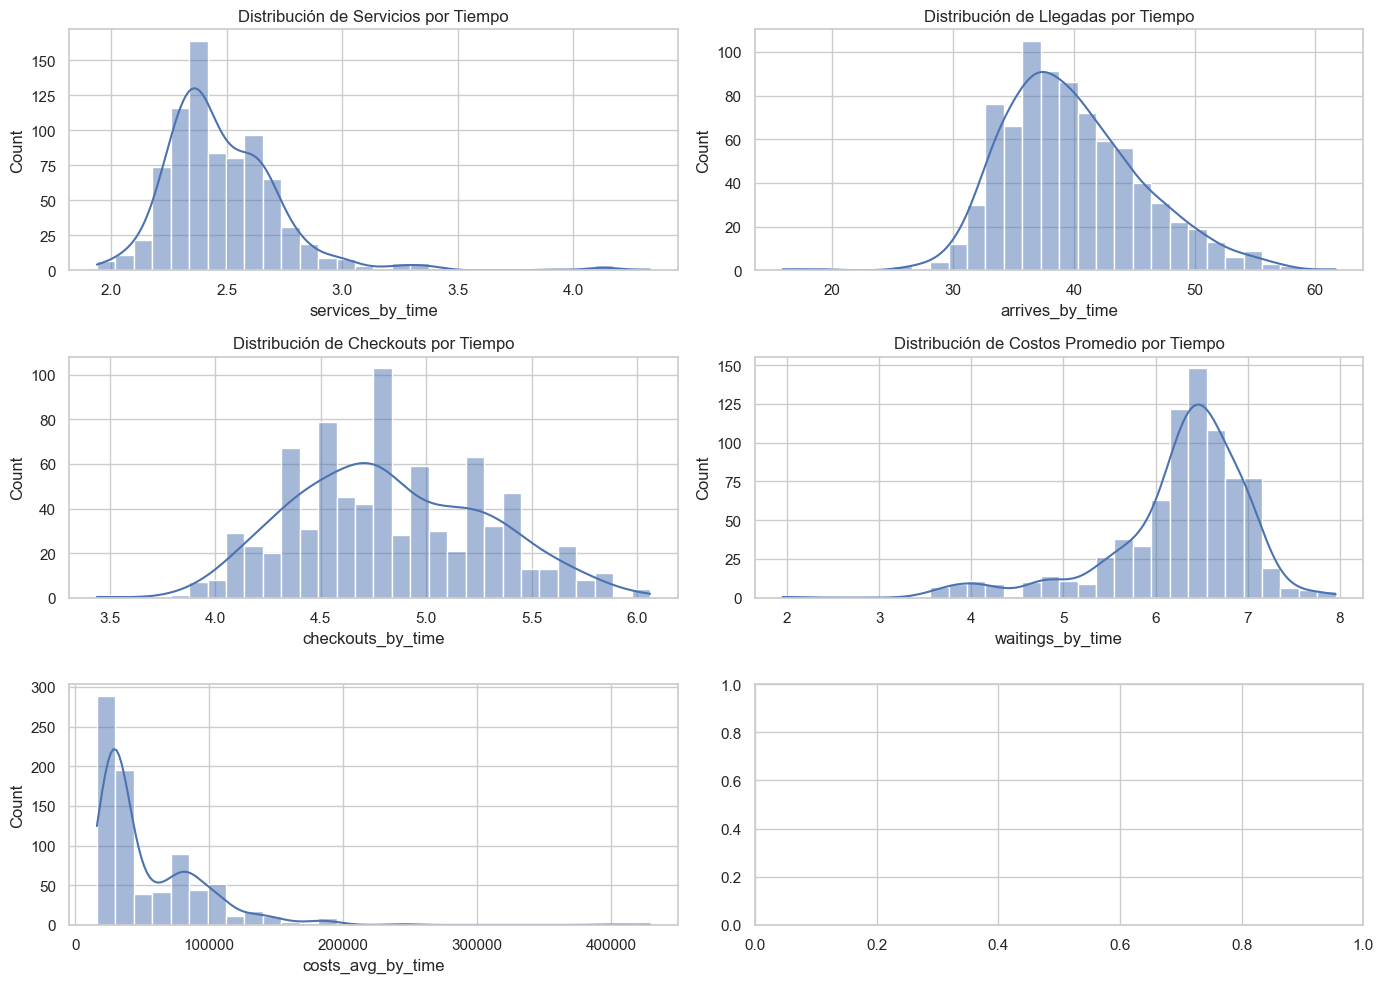

In [354]:
bins = 30 # Número de bins para los histogramas

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Gráfico para services_by_time
sns.histplot(data_group["services_by_time"], bins=bins, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Distribución de Servicios por Tiempo")
# Gráfico para arrives_by_time
sns.histplot(data_group["arrives_by_time"], bins=bins, ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Distribución de Llegadas por Tiempo")
# Gráfico para checkouts_by_time
sns.histplot(data_group["checkouts_by_time"], bins=bins, ax=axes[1, 0], kde=True)
axes[1, 0].set_title("Distribución de Checkouts por Tiempo")
# Gráfico para waitings_by_time
sns.histplot(data_group["waitings_by_time"], bins=bins, ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Distribución de Tiempos de Espera")
# Gráfico para costs_avg_by_time
sns.histplot(data_group["costs_avg_by_time"], bins=bins, ax=axes[2, 0], kde=True)
axes[1, 1].set_title("Distribución de Costos Promedio por Tiempo")

plt.tight_layout()
plt.show()

#### Generación de cajas Boxplots

En los gráficos de caja, podemos observar que, en el caso de los tiempos de espera (waitings), los outliers son más pronunciados. Esto indica que, aunque generalmente los tiempos de espera son bajos, existen ciertas eventualidades que provocan prolongaciones significativas en algunas ocasiones.

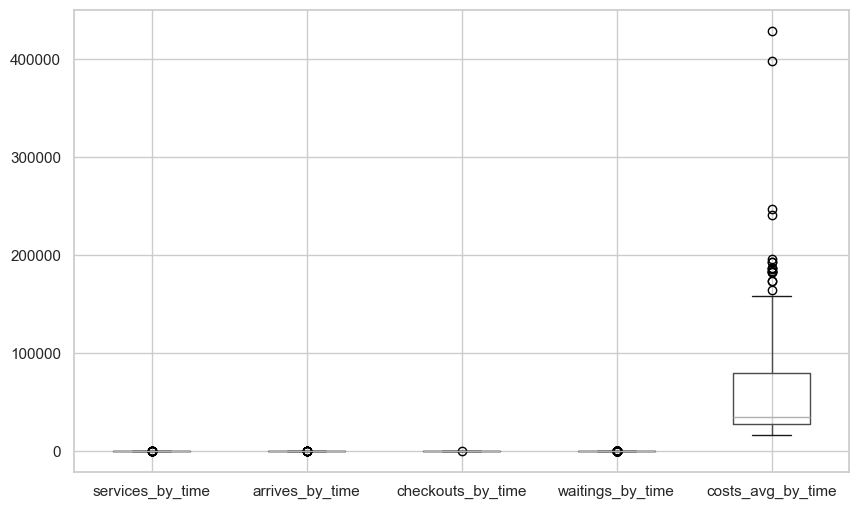

In [355]:
# Gráfico de caja para las métricas de interés

data_group.boxplot(column=["services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time","costs_avg_by_time"], figsize=(10, 6))
plt.show()

#### Identificación de valores atípicos (Outliers)

In [356]:
# Calcular los valores atípicos para las métricas de interés

outliers = data_group[["services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time","costs_avg_by_time"]].apply(lambda x: np.abs(x - x.mean()) > (3 * x.std()))
outliers.describe()

,services_by_time,arrives_by_time,checkouts_by_time,waitings_by_time,costs_avg_by_time
count,808,808,808,808,808
unique,2,2,2,2,2
top,False,False,False,False,False
freq,795,803,807,791,794


#### Conteo de valores (cardinalidad) para aquellos datos categoricos

Para este caso se contabilizó la frecuencia de registros por sucursal

In [357]:
# Conteo de registros por sucursal, contabilizado a los 1,000 registros de la consulta

data_suc = data_clean['store'].value_counts()
data_suc

store
ZCL    808
Name: count, dtype: int64

#### Análisis de tendencias (Tiempo de servicio)

Podemos observar una tendencia bastante variable en el tiempo de servicio promedio. Aunque en algunos casos los valores son bajos, en otros, los números son significativamente mayores que los promedios.

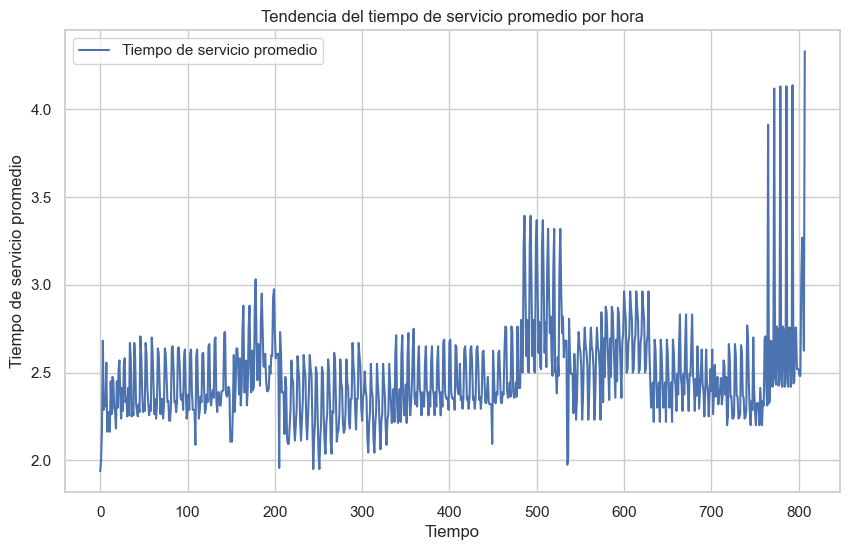

In [358]:
# Analisis de tendendia para los tiempo de servicio promedio

plt.figure(figsize=(10, 6))
plt.plot(data_group.index, data_group['services_by_time'], label='Tiempo de servicio promedio')
plt.title('Tendencia del tiempo de servicio promedio por hora')
plt.xlabel('Tiempo')
plt.ylabel('Tiempo de servicio promedio')
plt.legend()
plt.show()

#### Mapa de correlaciones

En este diagrama de correlación, podemos observar que las llegadas están fuertemente correlacionadas con los checkouts, seguidas por el tiempo de servicio. Esto es lógico, ya que un mayor número de llegadas requiere un mayor número de cajas abiertas. Al final, lo que buscamos es deducir cuántas cajas necesitamos tener abiertas para atender adecuadamente la demanda de una tienda en condiciones normales.

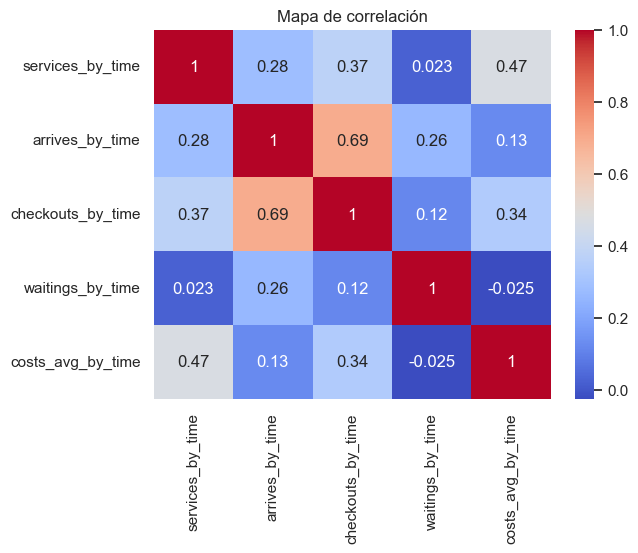

In [359]:
correlation = data_group[["services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time", "costs_avg_by_time"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Mapa de correlación')
plt.show()

#### Justificación y análisis de mapa de correlación

Identificar la correlación entre las ventas, el flujo de clientes y el número de cajas necesarias para satisfacer la demanda es crucial por varias razones:

*   **Optimización de Recursos**: Si existe una fuerte correlación, esto indica que a medida que aumenta el número de clientes, las ventas también crecen y se requiere más cajas. Conocer esta relación permite ajustar de manera eficiente el número de cajas y empleados necesarios durante las horas de mayor afluencia.
*   **Predicción más precisa**: Comprender cómo se relacionan estas variables ayuda a construir modelos predictivos más precisos. Un modelo que considere esta correlación puede captar patrones que otros modelos más simples podrían pasar por alto.
*   **Planificación Estratégica**: Analizar esta relación también brinda información sobre cómo los cambios en las ventas, promociones o incluso la disposición de la tienda pueden impactar tanto el flujo de clientes como las ventas, facilitando una mejor planificación a largo plazo.

## Parte 2, normalización de datos

En nuestro conjunto de datos, es necesario aplicar una transformación, ya que la mayoría de los datos están expresados en tiempo (minutos), a excepción de los checkouts, que presentan una distribución discreta.

In [360]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_group[["services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time", "costs_avg_by_time"]])
data_scaled = pd.DataFrame(data_scaled, columns=["services_by_time", "arrives_by_time", "checkouts_by_time", "waitings_by_time", "costs_avg_by_time"])
data_scaled.head()

,services_by_time,arrives_by_time,checkouts_by_time,waitings_by_time,costs_avg_by_time
0,-2.050324,-0.529682,-1.139368,1.705434,-0.827543
1,-1.815550,-1.449339,-1.692082,1.281309,-0.822584
2,-1.134704,-0.288819,-1.001190,1.436278,-0.778314
3,0.743491,0.641786,1.209664,2.219278,-0.484448
4,-0.735588,-1.098994,-1.415725,1.525997,-0.791244


In [361]:
from sklearn.preprocessing import StandardScaler

data_scaled = data_group.copy()

scaler = StandardScaler()
data_scaled['services_by_time'] = scaler.fit_transform(data_scaled[['services_by_time']])
data_scaled['arrives_by_time'] = scaler.fit_transform(data_scaled[['arrives_by_time']])
data_scaled['checkouts_by_time'] = scaler.fit_transform(data_scaled[['checkouts_by_time']])
data_scaled['waitings_by_time'] = scaler.fit_transform(data_scaled[['waitings_by_time']])
data_scaled['costs_avg_by_time'] = scaler.fit_transform(data_scaled[['costs_avg_by_time']])

Para el caso de la variable categorica "Sucursal" la codificaremos para poder realizar el entrenamiento posteriormente

In [362]:
from sklearn.preprocessing import LabelEncoder

# Ejemplo de codificación con LabelEncoder
#label_encoder = LabelEncoder()
#data_scaled['store'] = label_encoder.fit_transform(data_scaled['store'])
#data_scaled['date'] = label_encoder.fit_transform(data_scaled['date'])

In [363]:
data_scaled.head()

,store,date,avg_real_time_service,services_by_time,arrives_by_time,checkouts_by_time,waitings_by_time,costs_avg_by_time
0,ZCL,2017-02-22,151.656,-2.050324,-0.529682,-1.139368,1.705434,-0.827543
1,ZCL,2017-02-23,134.992,-1.815550,-1.449339,-1.692082,1.281309,-0.822584
2,ZCL,2017-02-24,146.285,-1.134704,-0.288819,-1.001190,1.436278,-0.778314
3,ZCL,2017-05-22,179.909,0.743491,0.641786,1.209664,2.219278,-0.484448
4,ZCL,2017-05-25,133.156,-0.735588,-1.098994,-1.415725,1.525997,-0.791244


In [364]:
data_scaled.to_csv('data_scaled_ZCL.csv', index=False)

Por último observaremos cómo se ven nuestros datos ya listos para ingresarlos al algoritmo de aprendizaje automático

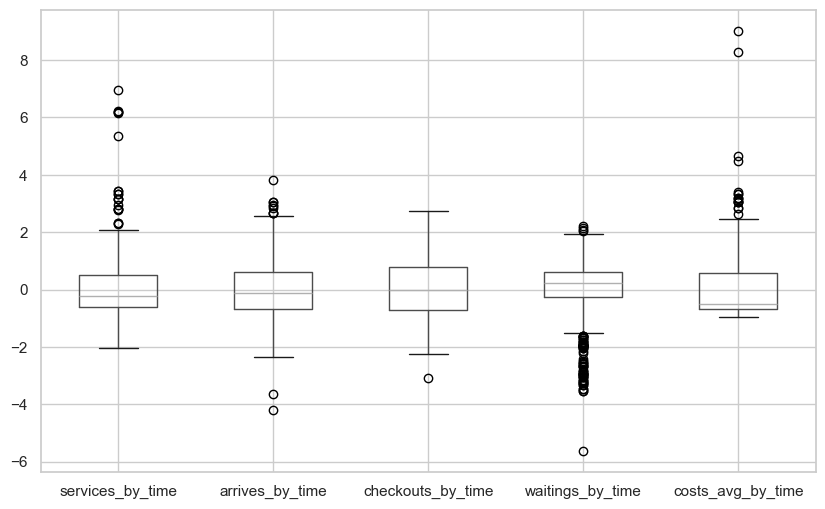

In [365]:
# Gráfico de caja para las métricas de interés escaladas

data_scaled.boxplot(column=['services_by_time', 'arrives_by_time', 'checkouts_by_time', 'waitings_by_time','costs_avg_by_time'], figsize=(10, 6))
plt.show()

### Parte 3: Modelado

In [366]:
from sklearn.model_selection import train_test_split

In [367]:
# Dividir los datos en conjuntos de entrenamiento y prueba

df_X = data_scaled[['services_by_time', 'arrives_by_time', 'waitings_by_time', 'costs_avg_by_time']]
df_y = data_scaled['checkouts_by_time']

In [368]:
df_X.head()

,services_by_time,arrives_by_time,waitings_by_time,costs_avg_by_time
0,-2.050324,-0.529682,1.705434,-0.827543
1,-1.815550,-1.449339,1.281309,-0.822584
2,-1.134704,-0.288819,1.436278,-0.778314
3,0.743491,0.641786,2.219278,-0.484448
4,-0.735588,-1.098994,1.525997,-0.791244


In [369]:
df_y.head()

0   -1.139368
1   -1.692082
2   -1.001190
3    1.209664
4   -1.415725
Name: checkouts_by_time, dtype: float64

In [370]:
# Separación de pruebas y entrenamiento con un 80% de datos de entrenamiento y 20% de datos de prueba

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

El primer modelo que analizaremos corresponde a una regresión lineal

In [371]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

El siguiente modelo a una regresion polinomial

In [372]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polynomial_model.fit(X_train, y_train)
y_pred_polynomial = polynomial_model.predict(X_test)

Por último un modelo baseline de regresión

In [373]:
from sklearn.dummy import DummyRegressor

baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
y_pred_DummyRegressor = baseline_model.predict(X_test)

Calculamos la precisión de cada modelo

In [374]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = {
    "Model": ["Linear Regression", "Polynomial Regression (Degree 2)","Dummy Regressor"],
    "Mean Squared Error": [
        mean_squared_error(y_test, y_pred_linear),
        mean_squared_error(y_test, y_pred_polynomial),
        mean_squared_error(y_test, y_pred_DummyRegressor)
    ],
    "Mean Absolute Error": [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_polynomial),
        mean_absolute_error(y_test, y_pred_DummyRegressor)
    ],
    "R-Squared": [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_polynomial),
        r2_score(y_test, y_pred_DummyRegressor)
    ]
}

Imprimimos las métricas obtenidas


In [375]:
# Crear un DataFrame con las métricas de evaluación de los modelos

df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,Mean Squared Error,Mean Absolute Error,R-Squared
0,Linear Regression,0.542345,0.562333,0.436557
1,Polynomial Regression (Degree 2),0.406807,0.505170,0.577368
2,Dummy Regressor,0.962558,0.798319,-0.000002


Como podemos observar el modelo de mejor rendimiento es el de regreción polinomial, esto nos podría dar indiciós a que referente a las distintas variables, el modelo se puede explicar de mejor forma teniendo un algoritmo que tome en cuenta los valores continuos esperados en la variable objetivo "Checkouts"

#### Aplicación de PCA (reducción de dimencionalidad)

Para validar el rendimiento de nuestros modelos se aplicará PCA para revisar si obtenemos un mejor rendimiento al momento de reducir la cardinalidad de los datos disponibles y analizaremos ambos resultados

In [376]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [377]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_X)

In [378]:
# Crear un DataFrame con los componentes principales

pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['int_checkouts'] = df_y.values

In [379]:
pca_df

,PCA1,PCA2,int_checkouts
0,-1.695300,1.837767,-1.139368
1,-2.068122,1.029874,-1.692082
2,-1.018726,1.517216,-1.001190
3,0.954120,1.988881,1.209664
4,-1.141171,1.115269,-1.415725
...,...,...,...
803,3.340905,-4.187149,0.000000
804,4.011178,-4.427889,0.000000
805,2.453542,-3.705017,0.000000
806,1.483106,-3.853930,0.000000


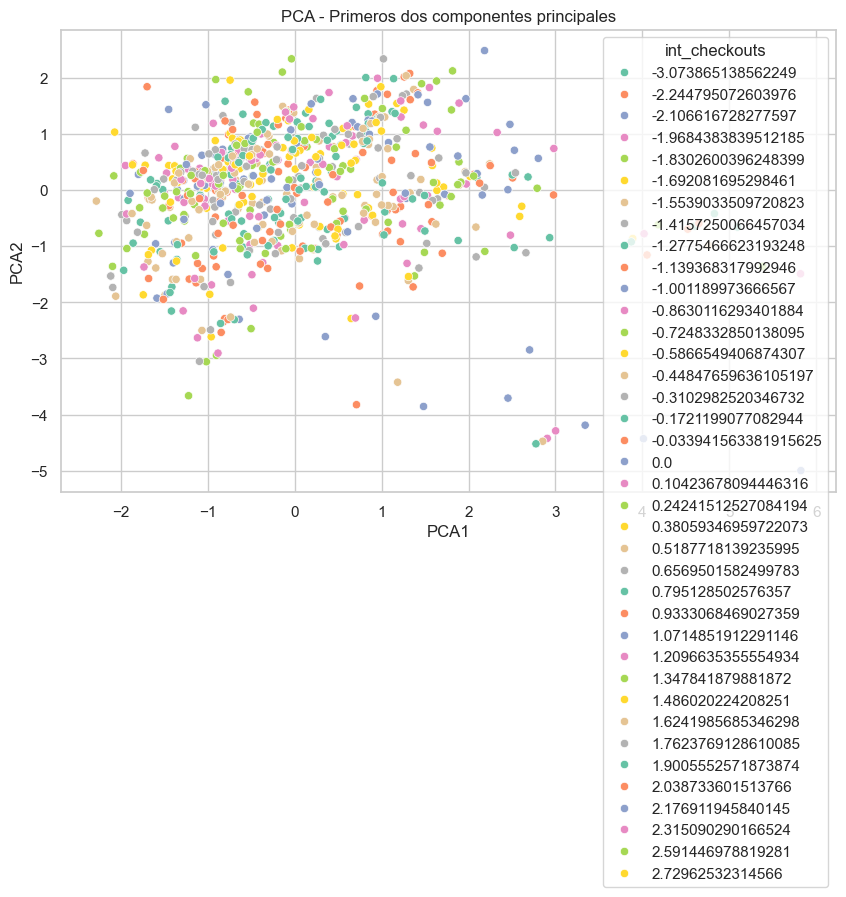

In [380]:
# Graficar los dos primeros componentes principales

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='int_checkouts', data=pca_df, palette='Set2')
plt.title('PCA - Primeros dos componentes principales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [381]:
# Mostrar la varianza explicada por los componentes principales

print(f"Varianza explicada por el primer componente: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Varianza explicada por el segundo componente: {pca.explained_variance_ratio_[1]:.4f}")

Varianza explicada por el primer componente: 0.4081
Varianza explicada por el segundo componente: 0.2928


In [382]:
# Crear un DataFrame con los componentes principales

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [383]:
# Linear regression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [384]:
# Polynomial regression with degree 2

polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polynomial_model.fit(X_train, y_train)
y_pred_polynomial = polynomial_model.predict(X_test)

In [385]:
metrics = {
    "Model": ["Linear Regression", "Polynomial Regression (Degree 2)","Dummy Regressor"],
    "Mean Squared Error": [
        mean_squared_error(y_test, y_pred_linear),
        mean_squared_error(y_test, y_pred_polynomial),
        mean_squared_error(y_test, y_pred_DummyRegressor)
    ],
    "Mean Absolute Error": [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_polynomial),
        mean_absolute_error(y_test, y_pred_DummyRegressor)
    ],
    "R-Squared": [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_polynomial),
        r2_score(y_test, y_pred_DummyRegressor)
    ]
}

In [386]:
# Crear un DataFrame con las métricas de evaluación de los modelos

df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,Mean Squared Error,Mean Absolute Error,R-Squared
0,Linear Regression,0.542345,0.562333,0.436557
1,Polynomial Regression (Degree 2),0.406807,0.505170,0.577368
2,Dummy Regressor,0.962558,0.798319,-0.000002


En general podemos ver que nos datos tienen un mejor rendimiento sin aplicar necesariamente PCA, por lo que para este caso el modelo se puede explicar de mejor forma con la cardinalidad base de nuestro modelo, esto de cierta forma es lógico debido a que nuestro set de datos no es muy amplio en variables disponibles.

## Parte 4 Generación de modelos de ML

Para esta sección de la práctica se generarán por lo menos 5 modelos de ML se analizarán los siguientes:
* Regresión lineal
* Regresión polinómica
* Árbol de decisión
* Random Forest
* XGBoost

De los cuales se obtendrá su rendimiento al momento de la ejecución, con la finalidad de poder determinar cuál de estos modelos es el más adecuado para nuestro set de datos propuesto.

In [387]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

1.- Algoritmo de Regresión lineal

Este tipo de algoritmos corresponde a uno de los más simples y ampliamente utilizados. Principalmente busca modelar la relación entre una variable dependiente y una o más variables independientes, ajustando una línea recta a los datos.
Dentro de las características principales tenemos las siguientes:
* Supone la existencia re una relación lineal entre las variables analizadas y la objetivo
* Facilidad en su interpretación y de rápido entrenamiento
* Puede llegar a sufrir de una baja capacidad en su predición si los datos de entrenamiento y prueba no son lineales

In [388]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
calculate_metrics(y_test, y_pred_linear, 'Linear Regression')

2.- Algoritmo de Regresión polinómica

Este tipo de algorimo toma como referencia la regresión lineal, siendo este una extención que permite capturar las relaciones NO lineales de entre las variables de nuestro data set elevando las varianbles a una potencia superior, con la finalidad de lograr un mejor resultado en variables más complejas.
Las principales caractierísticas de este modelo son las siguientes:
* Premite modelar datos no lineales
* Tiende a un sobreajuste si la dimencionalidad de los variables es muy alta
* Es adecuado cuando la relación esntre variables es compleja

In [389]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) # Algoritmo de grado 2
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)
y_pred_poly = poly_reg.predict(X_poly_test)
calculate_metrics(y_test, y_pred_poly, 'Polynomial Regression')

3.- Árbol de decisión

Este modelo crea un árbol donde cada uno de los nodos representa una variable, cada rama representa una regla de decisión y cada hoja representa el resultado. Las características de este modelo son las siguientes:
* Interpretación fácil
* Se adapta bien a los datos no lineales y puede manejrar datos numéricos y categóricos
* Es propenso al sobreajuste

In [390]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
calculate_metrics(y_test, y_pred_dt, 'Decision Tree')

4.- Random forest

Es un algoritmo basado en la conjunción de un bosque de árboles de decisión que lo hace más sobusto al momento de generar las predicciones. Sus características son las siguientes:
* Reduce el sobreajuste que puede ocurrir en el único árbol de decisión
* Generaliza bien en una variedad de problemas

In [391]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
calculate_metrics(y_test, y_pred_rf, 'Random Forest')

5.- XGBoost

Es una técnica de boosting basada en árboles de decisión. Mejora de manera iterativa los modelos basados en los errores de los modelos anteriores. Se ha convertido en un estándar para muchos problemas de machine learning debido a su rendimiento y velocidad.
* Alto rendimiento y eficiencia, especialmente en datasets grandes.
* Es capaz de manejar interacciones complejas entre las variables.
* Puede ser más difícil de interpretar que otros modelos como la regresión o los árboles de decisión.

In [392]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
calculate_metrics(y_test, y_pred_xgb, 'XGBoost')

6.- SVR

El modelo SVR extiende el concepto de las máquinas de soporte vectorial (SVM) para tareas de regresión. Intenta encontrar un hiperplano que tenga el margen máximo en un espacio de alta dimensionalidad, permitiendo cierto error dentro de un límite de tolerancia.
* Puede modelar relaciones complejas, no lineales, usando diferentes kernels (por ejemplo, el kernel radial).
* Es robusto a los outliers debido al uso de márgenes.
* El costo computacional puede ser alto, especialmente para datasets grandes.

In [393]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')  # Usamos el kernel RBF para la no linealidad
svr.fit(X_train, y_train.values.ravel())  # Aplanamos y_train a una matriz 1D
y_pred_svr = svr.predict(X_test)
calculate_metrics(y_test, y_pred_svr, 'SVR')

A continuación se viusaliza un cuadro comparativo del rendimiento de cada uno de los algoritmos analizados y el rendimiento obtenido bajo las méticas:
* MSE
* MAE
* R^2

In [394]:
results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE,R²
0,Linear Regression,0.542345,0.562333,0.436557
1,Polynomial Regression,0.406807,0.505170,0.577368
2,Decision Tree,0.712579,0.675539,0.259701
3,Random Forest,0.402782,0.512125,0.581550
4,XGBoost,0.460062,0.545796,0.522042
5,SVR,0.370395,0.481552,0.615197


C:\Users\SALVA\AppData\Local\Temp\ipykernel_17512\3405172280.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(results_df['Model'], rotation=90)
C:\Users\SALVA\AppData\Local\Temp\ipykernel_17512\3405172280.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(results_df['Model'], rotation=90)
C:\Users\SALVA\AppData\Local\Temp\ipykernel_17512\3405172280.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(results_df['Model'], rotation=90)


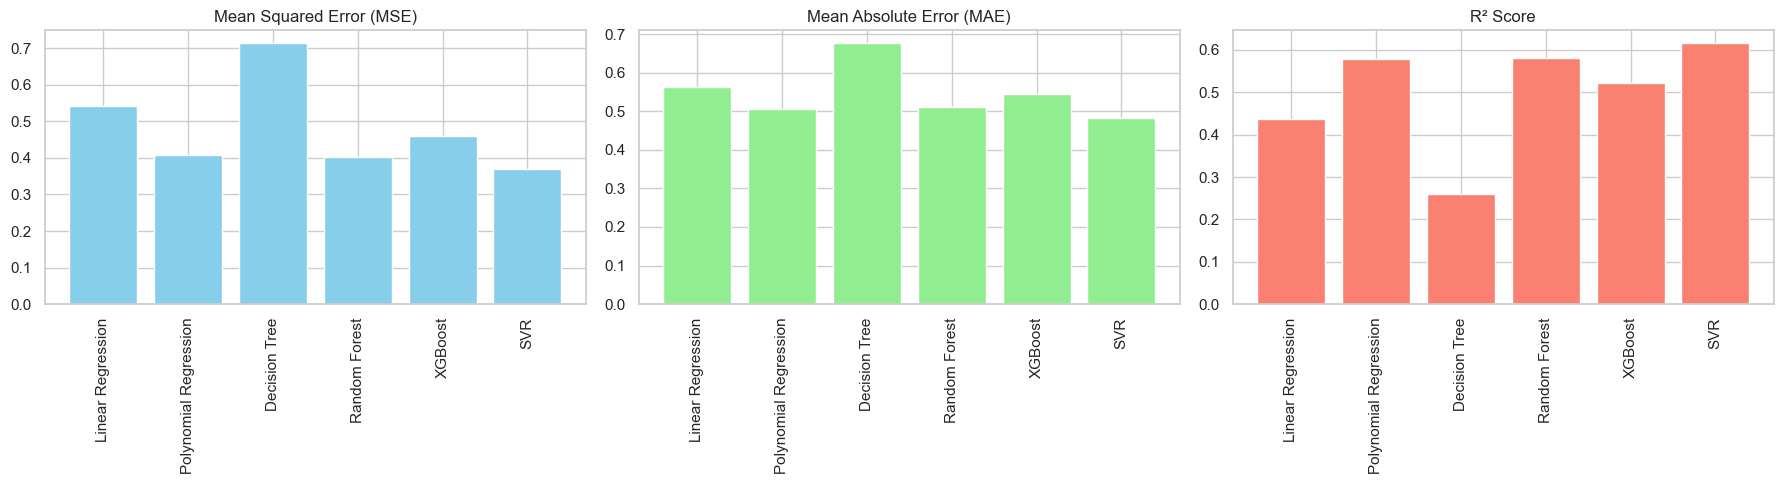

In [395]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfica de MSE
axes[0].bar(results_df['Model'], results_df['MSE'], color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xticklabels(results_df['Model'], rotation=90)

# Gráfica de MAE
axes[1].bar(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xticklabels(results_df['Model'], rotation=90)

# Gráfica de R²
axes[2].bar(results_df['Model'], results_df['R²'], color='salmon')
axes[2].set_title('R² Score')
axes[2].set_xticklabels(results_df['Model'], rotation=90)

plt.tight_layout()
plt.show()

En este caso podemos observar que nuestros mejores modelos son:
* Polynomial Regression
* Random Forest
* SVR

Por lo que como parte de esta práctica realizaremos un ajuste de hiperparámetros de cada uno de estos

## Avance 5. Modelo final

En la practica anterior habíamos definido un modelo Random Forest como el mejor, sin embargo, realizamos algunos ajustes en el proceso de alta de información y nos arrojó un mejor rendimiento el modelo SVR, por lo que cambiamos de definición en esta última práctica

#### Ajuste de hiperparámetros de los modelos seleccionados

In [396]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#### Ajuste de hiperparámetros para modelo Random Forest

In [397]:
# Hiperparámetros para ajustar en Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],         
    'max_depth': [None, 10, 20, 30],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],          
    'bootstrap': [True, False]               
}

In [398]:
# Ajuste de hiperparámetros Random Forest
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train.values.ravel()) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [399]:
print("Mejores hiperparámetros para Random Forest:")
print(rf_random.best_params_)

Mejores hiperparámetros para Random Forest:
{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [400]:
# Entrenamiento de Random Forest con los mejores hiperparámetros
best_rf = rf_random.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)

In [401]:
# Evaluar los modelos ajustados
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Random Forest Ajustado:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_best)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf_best)}")
print(f"R²: {r2_score(y_test, y_pred_rf_best)}")


Random Forest Ajustado:
MSE: 0.3935093681313401
MAE: 0.5020086849146143
R²: 0.5911830553600186


#### Ajuste de hiperparámetros para modelo SVR

In [402]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [403]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train.values.ravel())  # Ajuste del modelo

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [404]:
print("Mejores hiperparámetros para SVR:")
print(grid_search.best_params_)

Mejores hiperparámetros para SVR:
{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [405]:
# Entrenamiento de Random Forest con los mejores hiperparámetros
best_SVR = grid_search.best_estimator_
y_pred_svr_best = best_SVR.predict(X_test)

In [406]:
print("SVR Ajustado:")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr_best)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_svr_best)}")
print(f"R²: {r2_score(y_test, y_pred_svr_best)}")

SVR Ajustado:
MSE: 0.3703946227275203
MAE: 0.4815523466324545
R²: 0.6151969680071163


#### Ajuste de hiperparámetros para modelo Polynomial Regression

In [407]:
param_grid = {
    'polynomialfeatures__degree': [2, 3, 4, 5],  # Ajustar el grado del polinomio
    'linearregression__fit_intercept': [True, False]  # Ajuste de la intersección
}

In [408]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

In [409]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': [2, 3, 4, 5]},
             scoring='neg_mean_squared_error', verbose=2)

In [410]:
print("Mejores hiperparámetros para SVR:")
print(grid_search.best_params_)

Mejores hiperparámetros para SVR:
{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


In [411]:
# Entrenamiento de Random Forest con los mejores hiperparámetros
best_PR = grid_search.best_estimator_
y_pred_pr_best = best_PR.predict(X_test)

In [412]:
print("Regresión polinomial Ajustado:")
print(f"MSE: {mean_squared_error(y_test, y_pred_pr_best)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_pr_best)}")
print(f"R²: {r2_score(y_test, y_pred_pr_best)}")

Regresión polinomial Ajustado:
MSE: 0.40680732841392975
MAE: 0.5051696456742728
R²: 0.5773678023242697


Para este momento definimos el modelo SVR como aquel con mejores métricas, por lo que se selecciona como aquel con mejores resultados. Obtuvimos las siguientes métricas:
**Modelo SVR**
* MSE: 0.3703946227275203
* MAE: 0.4815523466324545
* R²: 0.6151969680071163

De lo que podemos observar un buen rendimiento en general con buenas métricas para el MSE y el MAE, en cuanto al R² es un poco bajo pero está compensado con las otras dos métricas

#### Modelos de Ensamble

En esta sección, se implementan dos enfoques de ensamble para mejorar el rendimiento del modelo base (SVR):

1. **Bagging con SVR**: Utiliza el modelo SVR como estimador base dentro de un Bagging Regressor. Con Bagging, se entrenan múltiples instancias del modelo SVR en diferentes muestras de entrenamiento para reducir la variabilidad y mejorar la estabilidad de las predicciones.

2. **Stacking con Múltiples Modelos**: Se crea un Stacking Regressor que combina tres modelos distintos: el SVR optimizado, una regresión Ridge y un árbol de decisión. Las predicciones de estos modelos se pasan a un modelo meta (Ridge), que aprende a combinar las predicciones para lograr una mejor precisión general.

Este enfoque de ensamble permite aprovechar las fortalezas de cada modelo, aumentando la capacidad de generalización y precisión del sistema predictivo.


In [413]:
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Ensamble Bagging con el parámetro actualizado a 'estimator'
bagging_svr = BaggingRegressor(estimator=best_SVR, n_estimators=10, random_state=42)
bagging_svr.fit(X_train, y_train)

# Ensamble Stacking con diferentes modelos
estimators = [
    ('svr', best_SVR),
    ('ridge', Ridge()),
    ('tree', DecisionTreeRegressor(max_depth=5))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('svr', SVR(C=1)), ('ridge', Ridge()),
                              ('tree', DecisionTreeRegressor(max_depth=5))],
                  final_estimator=Ridge())

#### Comparativa de datos

In [414]:
import time

# Lista para almacenar resultados
results = []

# Lista de modelos y nombres
model_names = ['SVR', 'Bagging SVR', 'Stacking']
models = [best_SVR, bagging_svr, stacking_model]

# Evaluar cada modelo
for name, model in zip(model_names, models):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    training_time = end_time - start_time
    
    results.append([name, rmse, mae, r2, training_time])

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R²', 'Training Time'])
results_df.sort_values(by='RMSE', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)
print(results_df)

         Model      RMSE       MAE        R²  Training Time
0          SVR  0.608601  0.481552  0.615197       0.000000
1  Bagging SVR  0.613322  0.487750  0.609203       0.031905
2     Stacking  0.635146  0.501913  0.580897       0.004046


c:\Users\SALVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\SALVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\SALVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Interpretación de SVR

Esta sección se enfoca en el Análisis de Residuos del modelo de Stacking basado en SVR. Un análisis de residuos es fundamental para evaluar el rendimiento de los modelos de regresión, ya que ayuda a identificar patrones en los errores y a verificar si el modelo es adecuado para los datos.

En general vemos una buena distribución de datos en referencia con nuestra línea ideal de resultados, por lo que podríamos deducir que nuestro modelo cuenta con un buen ajuste y un buen rendimiento, auqnue podríamos trabajar en reducir la posble generación de patrones en relación a los datos.

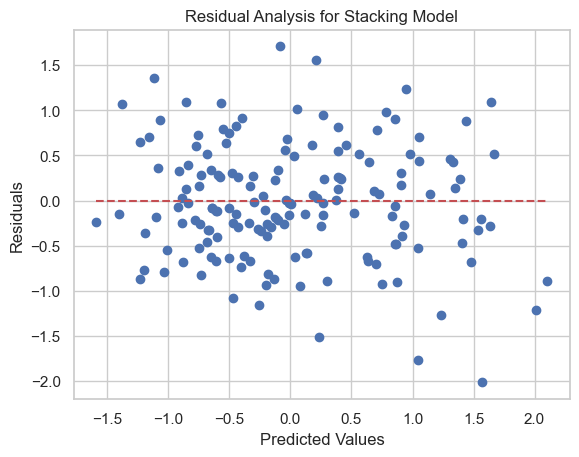

In [415]:
import matplotlib.pyplot as plt

# Predicciones y residuos para el mejor modelo
y_pred = stacking_model.predict(X_test)
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis for Stacking Model")
plt.show()

Importancia de características

En general el gráfico muestra una clara importancia de datos bajo la variable "arrives_by_time" que nos indica las llegadas por tiempo a una sucursal como aquella con más importancia en nuestro modelo

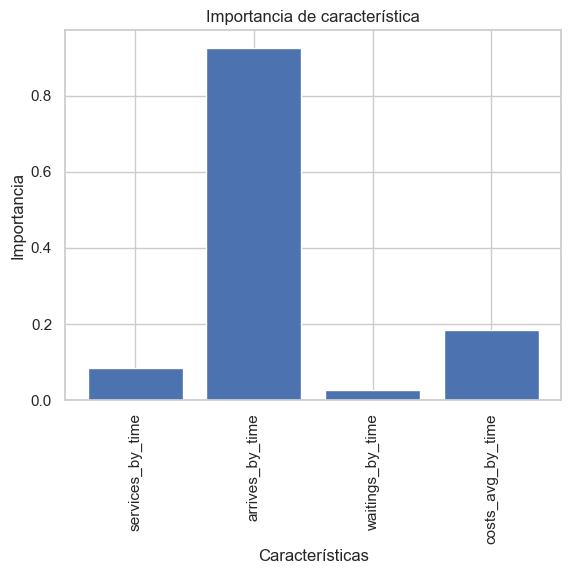

In [416]:
from sklearn.inspection import permutation_importance

# Importancia de características por permutación
importances = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)

# Gráfico de importancias
plt.figure()
plt.bar(X_train.columns, importances.importances_mean)
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de característica")
plt.show()

Tendencia y predicción

En general vemos una buena tendencia de predicción en contraste con los valores reales, como venimos observando en las secciones anteriores, nuestro modelo tiene en general un buen rendimiento y una buena precisión el momento de hacer las predicciones y lo podemos confirmar con este comparativo de tendencia vs predicción.

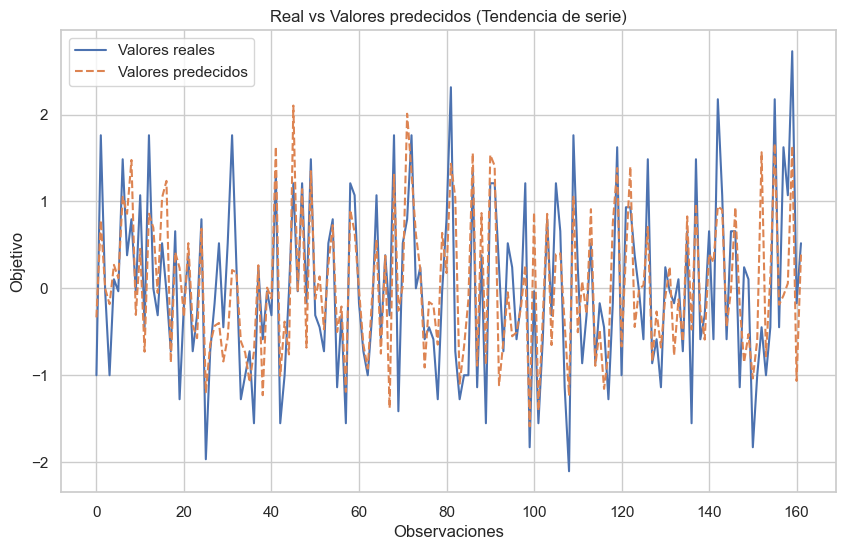

In [417]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label="Valores reales")
plt.plot(y_pred, label="Valores predecidos", linestyle='--')
plt.xlabel("Observaciones")
plt.ylabel("Objetivo")
plt.title("Real vs Valores predecidos (Tendencia de serie)")
plt.legend()
plt.show()

**Matriz de confusión**

En general podemos visualizar un balance entre las predicciónes positivas y negativas. Se puede visualizar un poco más inclinada la opción en donde falla con mayor frecuencia las predicciones negativas

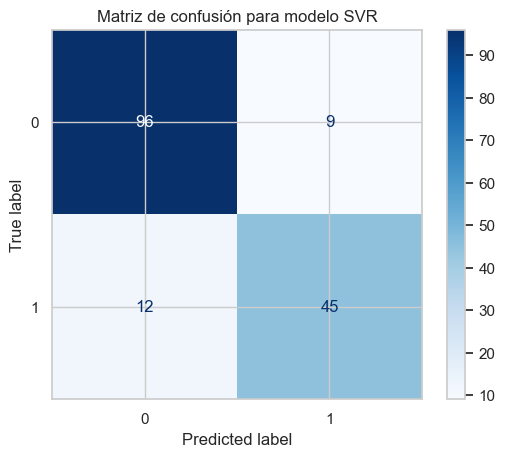

In [418]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Binarizer

y_pred_continuous = stacking_model.predict(X_test)
binarizer = Binarizer(threshold=0.3)  # Umbral
y_pred_classes = binarizer.fit_transform(y_pred_continuous.reshape(-1, 1)).astype(int)
y_test_binary = binarizer.fit_transform(y_test.values.reshape(-1, 1)).astype(int)


conf_matrix = confusion_matrix(y_test_binary, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión para modelo SVR")
plt.show()

**Curva de precisión**

En esta métrica podemos observar cómo nuestro modelo tiene un buen rendimiento al inicio, teniendo una precisión adecuada para los valores iniciales, sin embargo conforme el recall aumenta, cae de forma drática la precisión. Esto es tipico en la mayoría de los modelos, sin embargo, tendremos que trabajar en encontrar un blance referente a la precisión para encontrar los mejores valores de nuestro modelo.

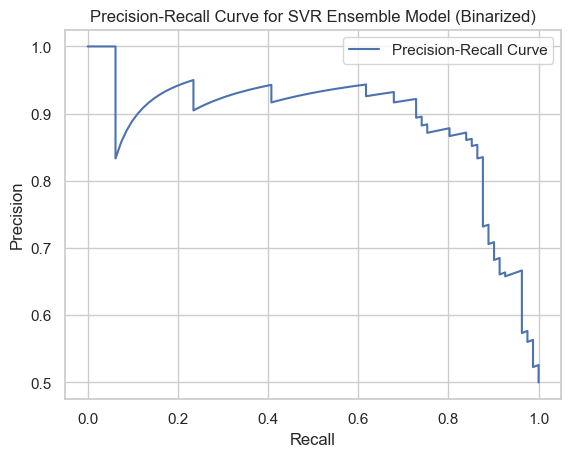

In [419]:
from sklearn.metrics import precision_recall_curve

threshold = np.median(y_test)

# Convertir y_test y las predicciones continuas en clases binarias
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred_continuous >= threshold).astype(int)

precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_continuous)

plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVR Ensemble Model (Binarized)")
plt.legend(loc="best")
plt.show()

#### Máquina de soporte vectorial para regresión (SVR)

La Máquina de Soporte Vectorial para Regresión (SVR, por sus siglas en inglés) es una extensión de las Máquinas de Soporte Vectorial (SVM) que se utiliza en problemas de regresión, en lugar de clasificación. En lugar de buscar un hiperplano que separe las clases, el SVR intenta encontrar una función que se aproxime a los datos dentro de un margen de error tolerable. La idea clave es minimizar el error de predicción sin tener en cuenta aquellos puntos que están dentro de una cierta distancia (llamada epsilon, ε) de la predicción. Este enfoque es especialmente útil en situaciones donde es importante obtener una predicción precisa sin sensibilidad excesiva a valores atípicos o ruido.

**Características Clave de SVR**

Margen de Error Controlado (ε): La SVR utiliza un margen de error alrededor de la línea de regresión, permitiendo que algunos puntos caigan dentro de este margen sin penalización. Esto ayuda a evitar el sobreajuste al reducir la sensibilidad del modelo a puntos específicosUso de Kernels: Al igual que las SVM para clasificación, la SVR puede aplicar funciones kernel (como lineal, polinomial, y radial) para transformar los datos a espacios de mayor dimensión, facilitando la captura de relaciones no lineales entre las variables .

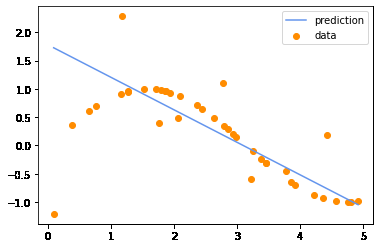

Referencias

Drucker, H., Burges, C. J., Kaufman, L., Smola, A., & Vapnik, V. (1997). Support vector regression machines. Advances in Neural Information Processing Systems, 9, 155-161.